# Modelling Record Prices From an Online Marketplace

### Contents

- [Data Dictionary](#0)
- [Exploratory Analysis](#6)
	- [Taking a look at things](#7)
	- [Principal Component Analysis](#8)
	- [Clustering](#9)
	- [Network Analysis](#10)
- [Regression Models](#11)
	- [Linear Regression](#12)
	- [Boosted Linear Regression](#13)
- [Classifiers](#14)
    - [Comparing Classifiers](#15)
	- [Ensemble Model](#16)
- [Applied Predictions](#17)

In [4]:
#data handling
import pandas as pd
import numpy as np

#graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import scikitplot as skplt
from matplotlib.colors import ListedColormap
import shap as shap

#clustering & network
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_samples, silhouette_score
from itertools import combinations
import networkx as nx
import operator

#preperation
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

#Regressors
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

#Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score

In [4]:
df7=pd.read_csv('/Users/josephstern/Desktop/project_files/df7.csv')
binary_cols=pd.read_csv('/Users/josephstern/Desktop/project_files/binary_cols.csv')
df7=df7.drop(columns='Unnamed: 0')

Records >£100= 203


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2a1dac50>]],
      dtype=object)

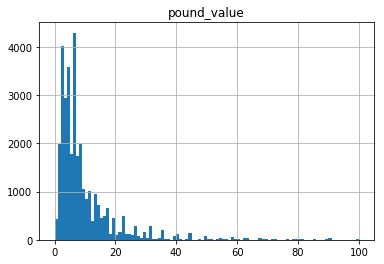

In [5]:
# ~ 2/3 of records are under £10
print('Records >£100=',len(df7[df7['pound_value']>100]))
df7[df7['pound_value']<100].hist(column='pound_value',bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e308e48>]],
      dtype=object)

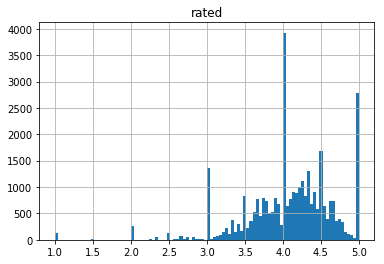

In [6]:
#most records have between 3 and 5 stars
df7.hist(column='rated',bins=100)

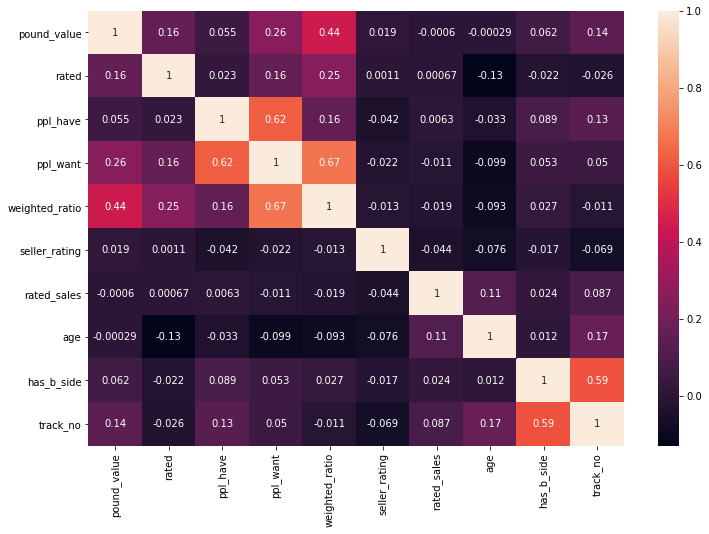

In [7]:
df7['age']=df7['year'].map(lambda x: int(2019-x))

ratio_w=[]
for record in zip(df7.ppl_want,df7.ppl_have):
    ratio_w.append(round(np.sqrt(record[0]**2/record[1]),2))

df7['weighted_ratio']=ratio_w

numeric=['pound_value','rated','ppl_have','ppl_want','weighted_ratio'
         ,'seller_rating','rated_sales','age','has_b_side','track_no']



#also seeing correlations between b-side & track no, age & track no
plt.figure(figsize=(12,8))
sns.heatmap(df7[numeric].corr(),annot=True)
plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<Figure size 576x576 with 0 Axes>

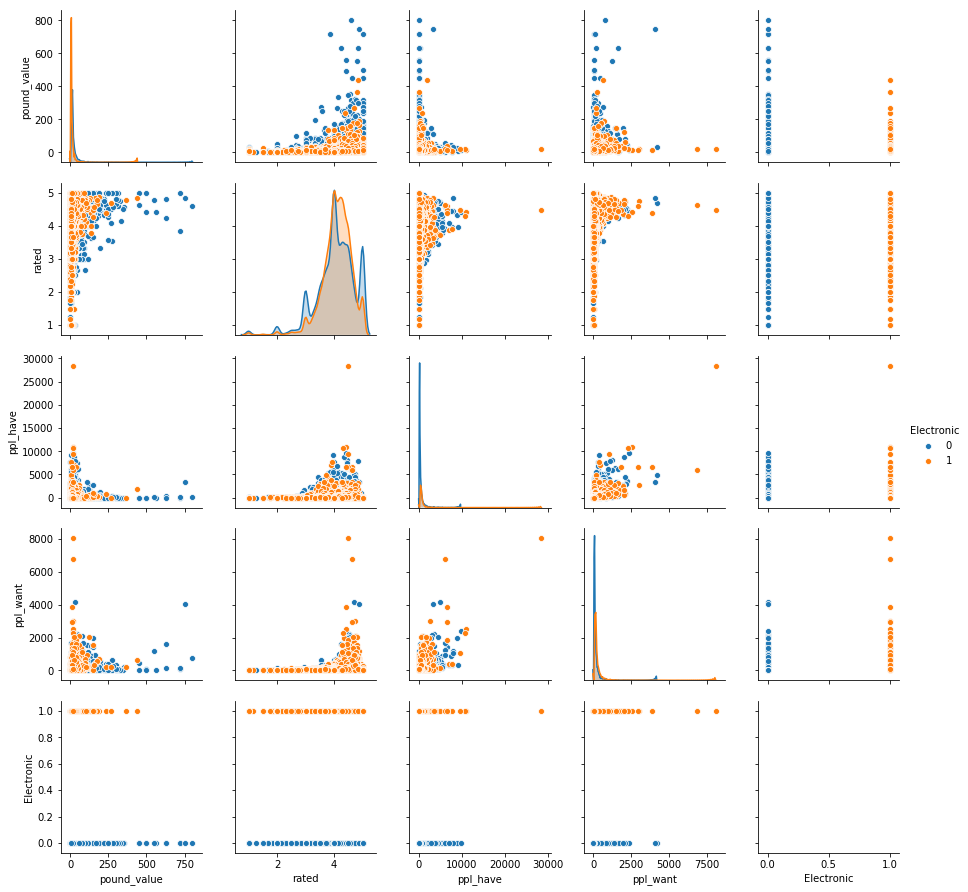

In [8]:
numeric2=['pound_value','rated','ppl_have','ppl_want','Electronic']
     
#Electronic vs non-Electronic music may show differences
df7['Electronic']=[int(x) for x in binary_cols['Electronic']]

#test=df7[df7.pound_value<100]

plt.figure(figsize=(8,8))
#sns.pairplot(test[numeric2],hue='Electronic')
sns.pairplot(df7[numeric2],hue='Electronic')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e37a160>]],
      dtype=object)

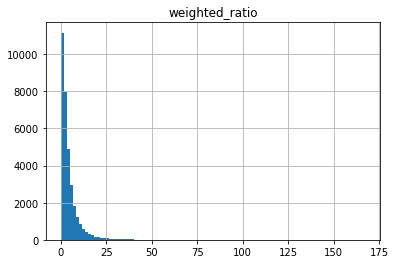

In [9]:
#most ratios are close to 0, would regard anything higher than 25 as a very high ratio
df7.hist(column='weighted_ratio',bins=100)

In [21]:
#expensive records have high ratios
df7.sort_values(by='pound_value', ascending=False).head(10)[['pound_value','artist','album','weighted_ratio']]

,pound_value,artist,album,weighted_ratio
33,801.00,David Bowie,The Man Who Sold The World,72.56
17211,750.00,Frank Ocean,Blond,70.89
46,720.00,Cizinha,Prá Fazer Um Samba / Pastorinhas,24.00
6423,719.96,Briard,I Really Hate Ya / I Want Ya Back,20.00
6734,630.00,David Bowie,David Bowie,89.37
6903,630.00,Harrison Jones & The Voices Of Harmony,The Power Of The Lord,90.07
18517,562.50,Athenians Of Toronto,Σαν Σκοτεινιάζει,12.91
30199,552.99,Minority Band,Journey To The Shore,167.38
31658,499.99,John Mayall And Eric Clapton,Lonely Years,13.86
6864,495.00,Heaven's Sound,Heaven's Sound,34.06


In [22]:
#i just want to see the top 17 countries for origin and exporting, categorising the rest as other
ship_countries=list(pd.DataFrame(df7.ships_from.value_counts().reset_index()).head(17)['index'])

origin_countries=list(pd.DataFrame(df7.country_origin.value_counts().reset_index()).head(17)['index'])

df7['ships_from']=[x if x in ship_countries else 'Other' for x in df7.ships_from]
df7['country_origin']=[x if x in origin_countries else 'Other' for x in df7.country_origin]

vinyl_condition


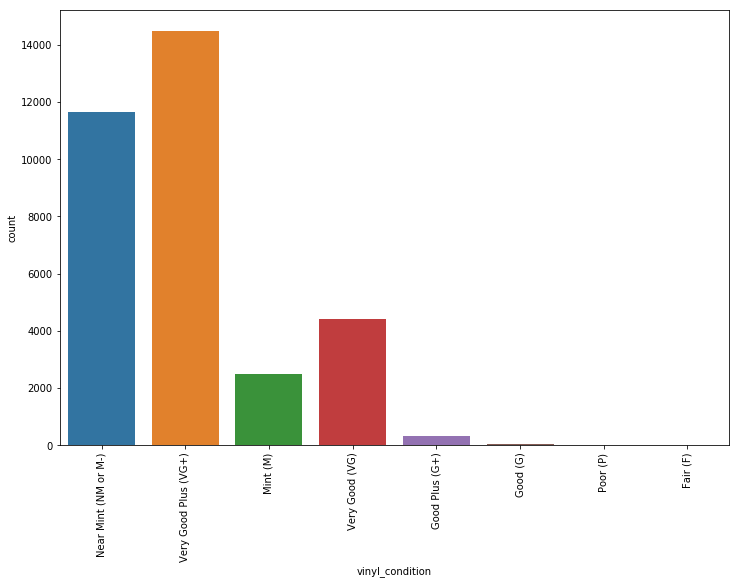

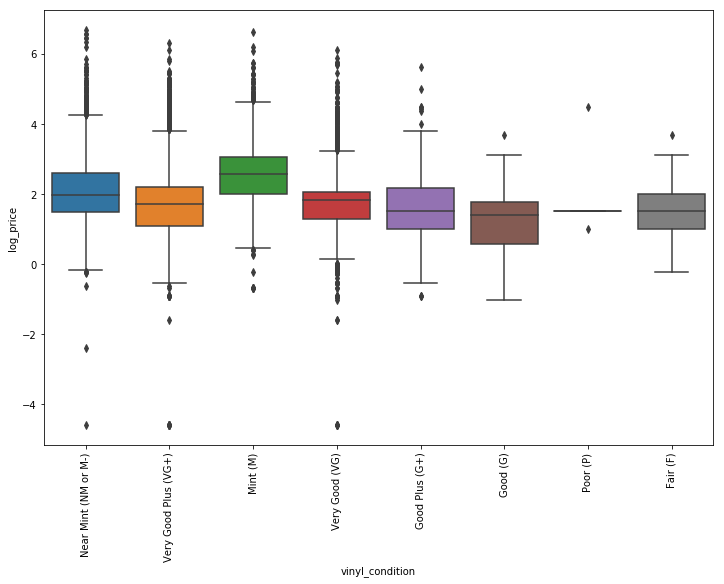

sleeve_condition


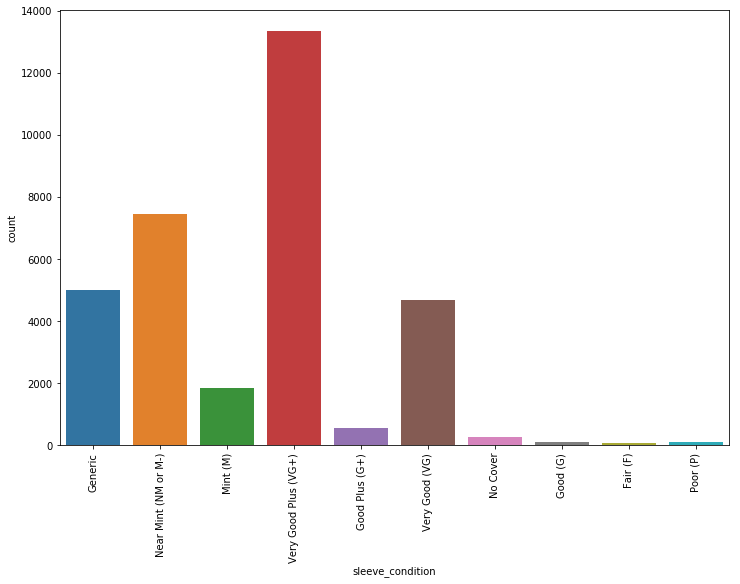

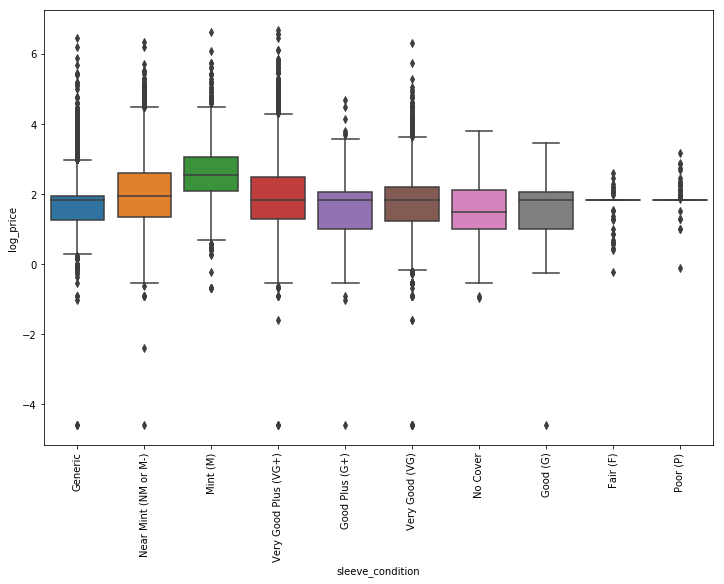

ships_from


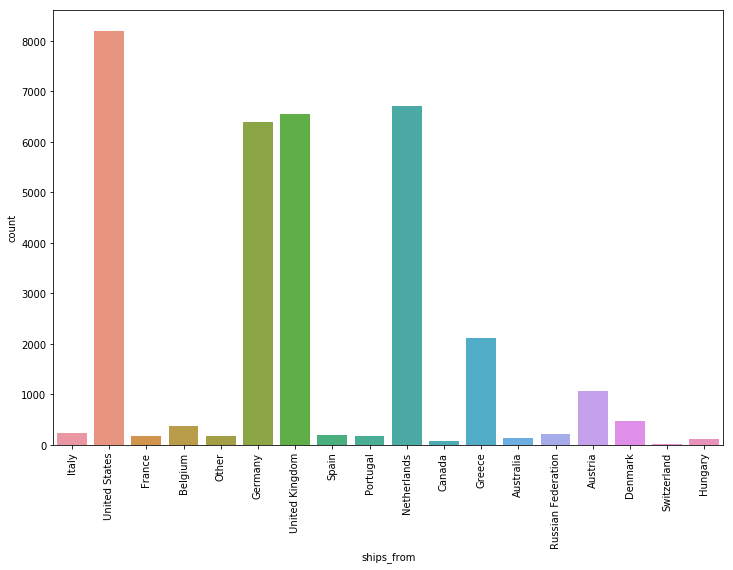

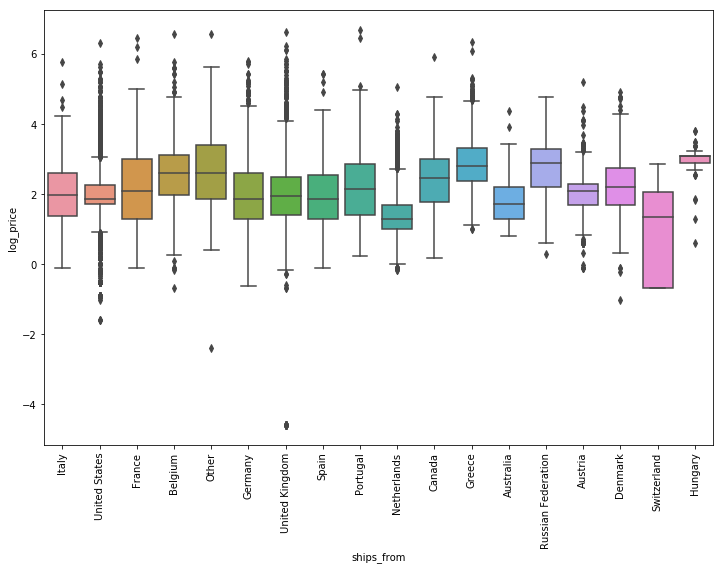

country_origin


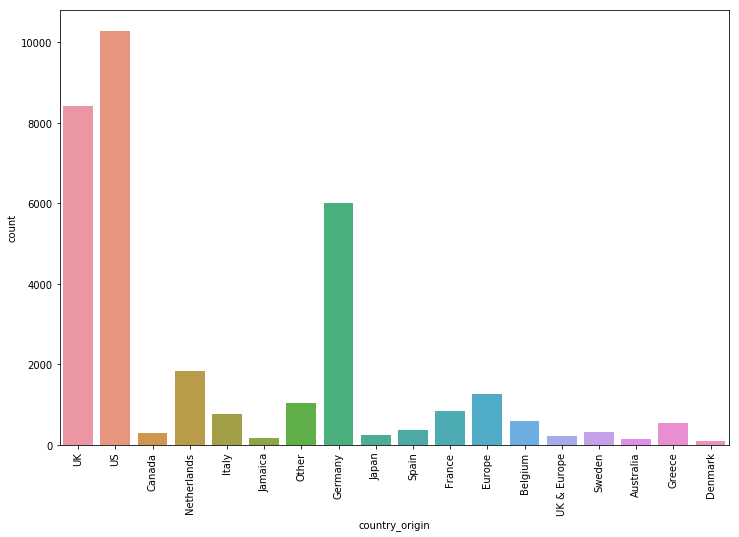

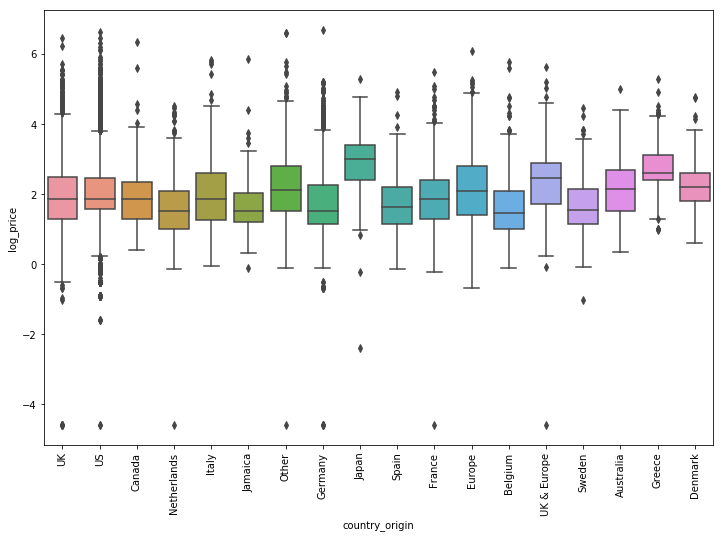

has_b_side


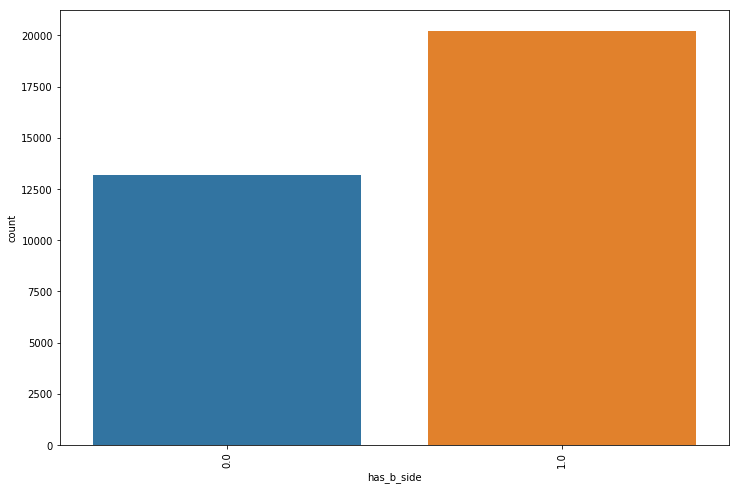

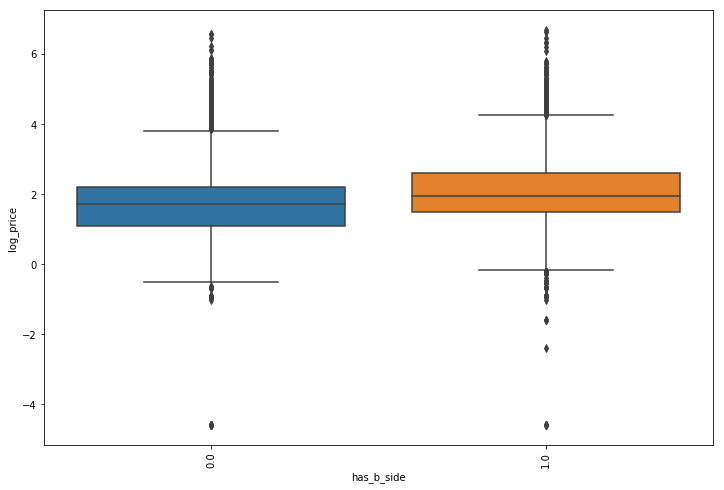

Electronic


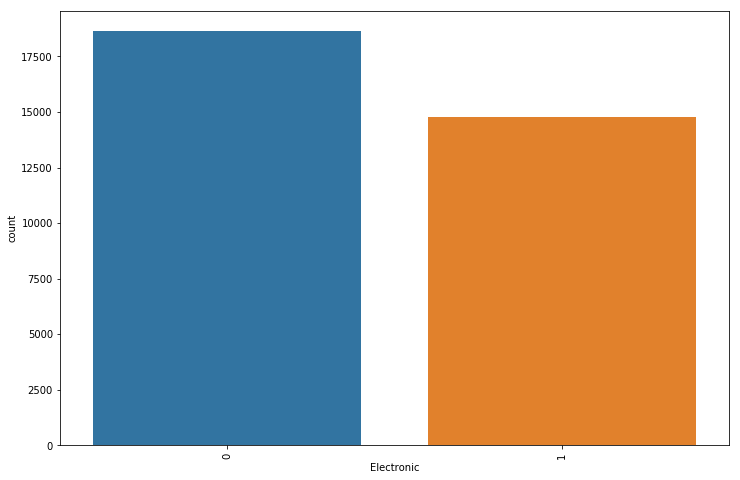

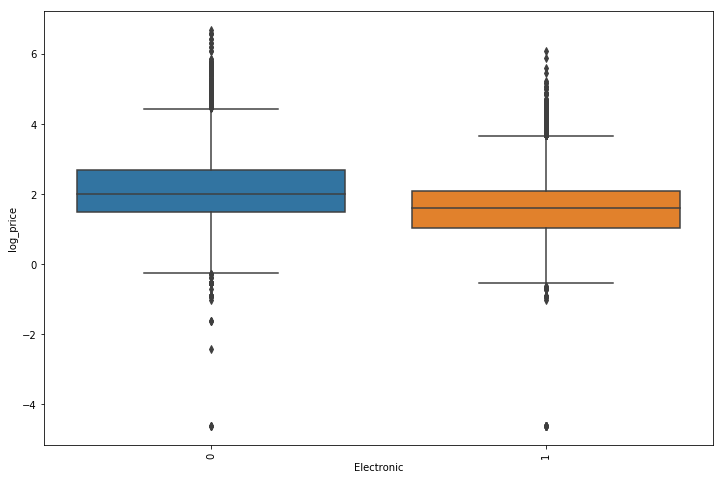

age


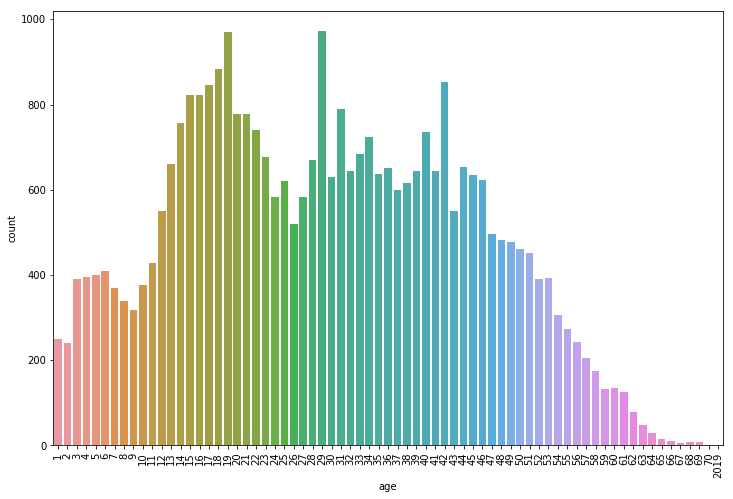

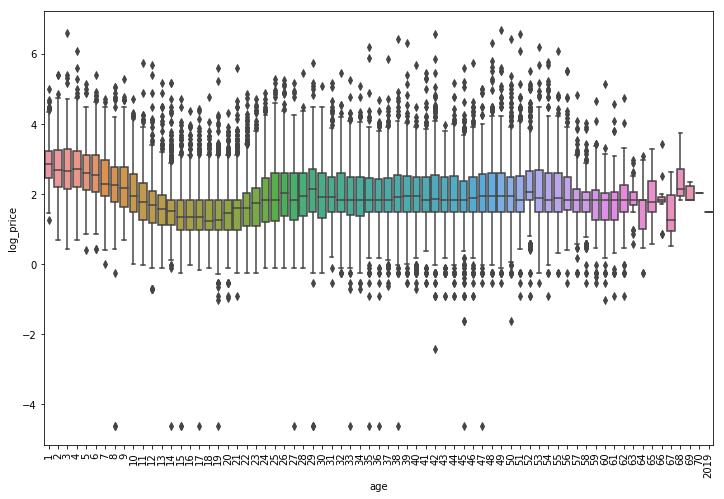

In [23]:
cats=['vinyl_condition','sleeve_condition','ships_from','country_origin','has_b_side','Electronic','age']

df7['log_price']=[np.log(x) for x in df7.pound_value]

def plot_function(var):
    plt.figure(figsize=(12,8))
    ax= sns.countplot(data=df7, x =var)
    plt.xticks(rotation=90)
    plt.show()
    return ax

def plot_function2(var,target='pound_value'):
    plt.figure(figsize=(12,8))
    ax= sns.boxplot(data = df7, x=var, y=target)
    plt.xticks(rotation=90)
    plt.show()
    return ax

for i in cats:
    print(i)
    plot_function(i)
    plot_function2(i,'log_price')
    

## Engineering a Variable For Genres & Styles

I tried putting all the previous variables plus genre (12 genres in total) into a simple regression model, and found that rock & electronic had a place in the model. I then tried using sub-genres (400+ styles), which gave me a weaker model and no coefficients.

Rock and electronic are very broad categories, so I'm creating clusters to divide the 2, and hopefully generate something more useful in the model.

<a id="8"></a>
<a id="9"></a>
### PCA & K-mean Clusters

In [26]:
#Reducing a binary matrix of style, label, age & country of origin to 3 columns

#Adding Label and age to the Binarized mix
test=pd.get_dummies(df7[['label','age','country_origin']],columns=['label','age','country_origin'])
len(test.columns)

matrix1=binary_cols[style_list].join(test)

scaler = StandardScaler()
matrix2 = pd.DataFrame(scaler.fit_transform(matrix1),columns=matrix1.columns)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Explained variance: [0.294 0.216 0.107]
       PC_1      PC_2      PC_3
0 -0.668947 -0.465605 -0.164452
1  0.768610 -0.229969 -0.172483
2 -0.070231  0.110273  0.060144
3 -0.086678  0.143393  0.307484
4 -0.617474 -0.365036 -0.416469


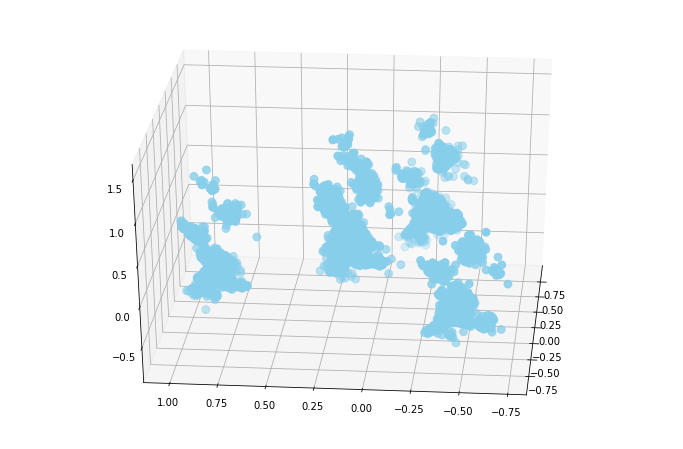

In [27]:
# Several clusters can clearly be seen in the graph below, but 2 of them are just mega rock & electronic clusters, and
# were the only 2 clusters significant in the model. 

pca = PCA(n_components=3)
cols = ['PC_{}'.format(i) for i in range(1,pca.n_components+1)]

#this is working better on non-standardized data
X_pca_3 = pd.DataFrame(pca.fit_transform(matrix1),columns=cols)

print("Explained variance:", np.round(pca.explained_variance_, 3))
print(X_pca_3.head())


kmeans = KMeans(n_clusters=15)
clusters = kmeans.fit_predict(X_pca_3)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3['PC_1'], X_pca_3['PC_2'], X_pca_3['PC_3'],c='skyblue', s=60)
ax.view_init(30, 185)
plt.show()

Explained variance: [4.666 3.826 3.407 3.38  3.133]
       PC_1      PC_2      PC_3       PC_4      PC_5
0 -0.394784  1.817356  1.095521  11.480041  0.424609
1  0.192998 -1.838728  0.336935  -0.074925 -1.524399
2 -0.097348 -0.429994 -0.087325  -0.057293 -0.228558
3 -0.384704  0.317038 -0.537109  -0.508783  0.238291
4  0.050674 -1.265087 -0.530775   0.231819 -0.246454


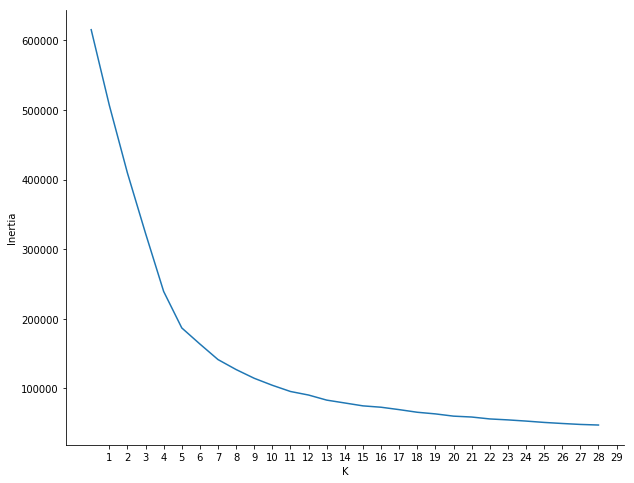

In [28]:
# Now trying 5 principal components. The elbow plot shows diminishing inertia scores after just a few clusters
# This means theres not a lot of difference seperating the data, but there is definitely difference in the sound.

pca = PCA(n_components=5)
cols = ['PC_{}'.format(i) for i in range(1,pca.n_components+1)]

#this is working better on non-standardized data
X_pca_5 = pd.DataFrame(pca.fit_transform(matrix2),columns=cols)

print("Explained variance:", np.round(pca.explained_variance_, 3))
print(X_pca_5.head())

inertias = []
for i in range(1,30):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_pca_5)
    inertia = kmeans.inertia_
    inertias.append(inertia.mean())

plt.figure(figsize=(10, 8))
plt.plot(inertias)
plt.ylabel("Inertia")
plt.xlabel("K")
plt.xticks(range(1,30))
sns.despine()

<a id="10"></a>
### Network Analysis 

Clustering offered no improvement on just using genre in the model, as the 2 main clusters are still just proxies for Rock & Electronic.
I'll hopefully be able to unravel those 2 groups a bit more by looking at networks of sub-genres within them.

Given the nature of the data I scraped (styles were lists of several rather than just 1 style), I'm going to create a flat list of all the tuple pairings per album then analyse the data on a different level to everything before. 

In [31]:
#top sub-genres per genre

Electronic=['House','Techno','DrumnBass','Disco','Synth-pop','TechHouse','DeepHouse','Electro','Trance','Minimal',
           'Experimental','NewWave','ProgressiveHouse','Downtempo','Breakbeat','GarageHouse','RnB/Swing',
           'ProgressiveTrance','Ambient','Dub','Breaks','Jungle','Acid','HardHouse','HardTrance','EuroHouse',
            'Tribal','Swing','TribalHouse','Dubstep','UKGarage','Hip-House','Europop','HiNRG','BassMusic',
            'Industrial','Gabber']

Rock=['PopRock','Punk','PsychedelicRock','Hardcore','AlternativeRock','ClassicRock','Rock&Roll','IndieRock',
      'FolkRock','Country','HardRock','ProgRock','BluesRock','Rhythm&Blues','EasyListening','Folk','GarageRock',
      'Ballad','Soundtrack','SoftRock','HeavyMetal','CountryRock','Fusion','ArtRock','Jazz-Rock','Thrash','Acoustic',
      'Thrash','StonerRock','Glam','Noise','Krautrock','Leftfield','DeathMetal','GothRock','Modern'
      ,'Rockabilly','SpaceRock','DoomMetal','SymphonicRock','BlackMetal','Surf','Lo-Fi','SouthernRock'
      ,'Ska','PostRock','Grunge','ArenaRock','Mod','Shoegaze','ElectricBlues']

In [32]:
# plotting a network diagram of all the connetions between sub-genres, then removing the most divisive links, to 
# hopefully unearth distinct communities within the mega-rock and electronic sectors.

def network_function(rock_or_electronic):
    
    nodes_to_use=rock_or_electronic
    
    #only want records where 2+ of the styles are in the list
    usable=[]  
    for record in test_style:
        x=0
        for style in nodes_to_use:
            if style in record:
                x+=1
        usable.append(x)
    
    test=pd.DataFrame({'test':test_style,'usable':usable})
    
    #dropping records with less than 1 style in specified list
    test2=test[test.usable>1]['test']
    len(test2)
    
    #Turning list into list of tuples
    node_pairs=[]
    for i in test2:
        node_pairs.append([x for x in combinations(i,2)])

    #at this stage I dont care about results lining up with records as i won't be able to trace them back
    flattened_list = [y for x in node_pairs for y in x]
    network_df=pd.DataFrame(flattened_list,columns=['a','b'])

    #Dataset in the right format to be mapped to a network graph
    test=network_df.groupby(['a','b']).size().reset_index().rename(columns={0:'weight'})
    network_df2=test[test['weight']>10]
    max_path=max(network_df2.weight)

    #generate an empty graph
    G = nx.Graph()

    #define the nodes
    for i in nodes_to_use:
        G.add_node(i)

    #link the nodes
    for index, row in network_df2.iterrows():
        G.add_edge(row['a'],row['b'],weight=row['weight']/max_path)

    #plotting
    def Girvan_Newman(G_1):
        G = G_1.copy()
        pos = nx.drawing.spring_layout(G)
        sorted_bc = [1]
        actual_number_components = 1
        while not sorted_bc == []:
            d_edge = nx.edge_betweenness_centrality(G)
            sorted_bc = sorted(list(d_edge.items()), key=operator.itemgetter(1))
            e = sorted_bc.pop()
            print("deleting edge:", e[0], end=' ')
            G.remove_edge(*e[0])
            num_comp = nx.number_connected_components(G)
            print("...we have now ",num_comp," components")
            if num_comp > actual_number_components:
                actual_number_components = num_comp
                if num_comp < 50:
                    plt.figure(figsize=(12, 12))
                    nx.draw(G, pos,with_labels=True)
                    plt.show()
                
    Girvan_Newman(G)
    

highlights from applying Girvan Newman Method on rock & electronic. After several iterations of edge removal, we see the sub networks below.

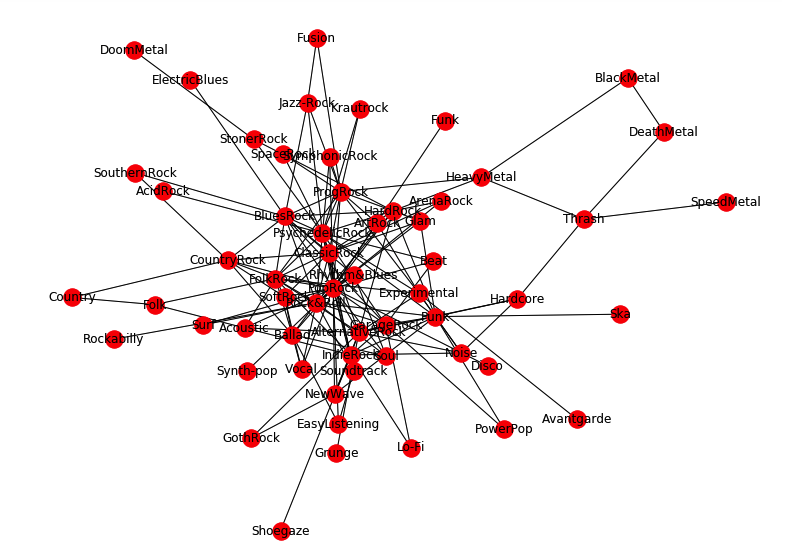

In [17]:
from IPython.display import Image
Image(filename='/Users/josephstern/Desktop/project_files/code-git/images/rock network.png',width=800, height=400)

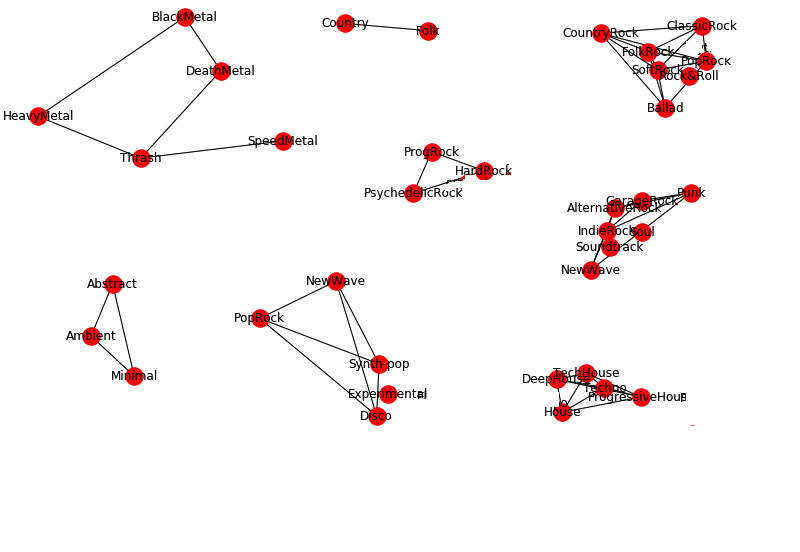

In [16]:
Image(filename='/Users/josephstern/Desktop/project_files/code-git/images/networks.png',width=800, height=400)

In [36]:
#with a carefully ordered if else statement I can split these sub-genres from their genres and create a hybrid field

test2=pd.DataFrame(test_genre).join(binary_cols).rename(columns={0:'first_genre'})

community=[]
for i in test2.index:
    if test2['Rock'][i]==1:
        
        if test2['HeavyMetal'][i]==1:
            community.append('metal')
        elif test2['Country'][i]==1:
            community.append('country')
        elif test2['Experimental'][i]==1:
            community.append('experimental_rock')
        elif test2['PsychedelicRock'][i]==1:
            community.append('psychedelic_rock')
        elif test2['Punk'][i]==1:
            community.append('punk')
        elif test2['ClassicRock'][i]==1:
            community.append('classic_rock')
        else:
            community.append('other_rock')
            
    elif test2['Electronic'][i]==1:
        
        if test2['Synth-pop'][i]==1:
            community.append('synth_pop')
        elif test2['Minimal'][i]==1:
            community.append('minimal')
        elif test2['Trance'][i]==1:
            community.append('trance')
        elif test2['DrumnBass'][i]==1:
            community.append('drumnbass')
        elif test2['House'][i]==1 or test2['Techno'][i]==1:
            community.append('house/techno')
        else:
            community.append('other_electronic')
    else:
        community.append(test2['first_genre'][i])

<a id="11"></a>
### Model Preparation

In [37]:
#seller columns were rubbish. 
df7['community']=community

df8=df7.drop(columns=['artist','album','wh_ratio','ppl_want','ppl_have',
                      'seller','seller_rating','rated_sales','url','year',
                      'has_b_side','Electronic','log_price','label'])

df8.info()


df9=pd.get_dummies(df8,columns=['vinyl_condition','sleeve_condition','ships_from',
                              'country_origin','community'],drop_first=True)

df9.to_csv(('/Users/josephstern/Desktop/project_files/df9.csv'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33414 entries, 0 to 33413
Data columns (total 10 columns):
pound_value         33414 non-null float64
rated               33414 non-null float64
weighted_ratio      33414 non-null float64
vinyl_condition     33414 non-null object
sleeve_condition    33414 non-null object
ships_from          33414 non-null object
country_origin      33414 non-null object
track_no            33414 non-null float64
age                 33414 non-null int64
community           33414 non-null object
dtypes: float64(4), int64(1), object(5)
memory usage: 2.5+ MB


In [42]:
df9=pd.read_csv('/Users/josephstern/Desktop/project_files/df9.csv')
binary_cols=pd.read_csv('/Users/josephstern/Desktop/project_files/binary_cols.csv')
df9=df9.drop(columns='Unnamed: 0')

acceptable_formats=['Vinyl','LP','Album','12"','45RPM','33⅓RPM',
                '7"','Single','2×','Compilation','EP','Reissue',
                'Stereo','Promo','Mono','Gatefold','Maxi-Single','3×']


df10=df9.join(binary_cols[acceptable_formats])
len(df10)

33414

In [39]:
#i'll need these at the very end
urls=df7[df7.pound_value<100]['url']

<a id="12"></a>
## Regression Modelling

In [43]:
#Considering records >£100 as outliers, that variance can't be explained by the data 
df10=df10[(df10.pound_value <100) ]
len(df10)

#df10['pound_value']=[np.log(x) for x in df10.pound_value]

y=df10.pop('pound_value')
X=df10

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5,random_state=1)

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


### Simple Linear Regression

Taking the log of y gives a higher performing model but I wanted one model with easily interpreted results. This model can also help explain the direction (+ or -) of feature importances for Machine Learning Models used later.

train score: 0.346
test score: 0.342
Intercept: 9.88
                                      var     coeff
82                                    12" -0.792019
29                 ships_from_Netherlands -0.427531
79                                  Vinyl -0.337304
70                 community_house/techno -0.301435
73             community_other_electronic -0.166287
9          vinyl_condition_Very Good (VG) -0.139153
10   vinyl_condition_Very Good Plus (VG+) -0.132567
36               ships_from_United States -0.067004
84                                 33⅓RPM -0.037026
18        sleeve_condition_Very Good (VG) -0.015665
76                         community_punk  0.012387
69            community_experimental_rock  0.013093
71                        community_metal  0.055165
21                     ships_from_Belgium  0.066854
87                                     2×  0.084426
15  sleeve_condition_Near Mint (NM or M-)  0.106995
46                   country_origin_Japan  0.230684
14         

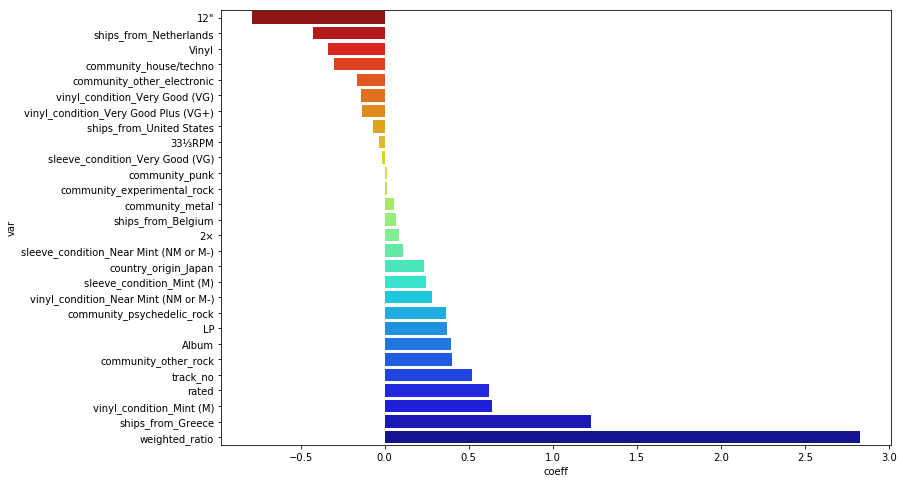

In [52]:
#model=LinearRegression()
#model=Lasso()
model=ElasticNet()

model.fit(X_train,y_train)

print('train score:',round(model.score(X_train,y_train),3))
print('test score:',round(model.score(X_test,y_test),3))

print('Intercept:',round(model.intercept_,2))
results=pd.DataFrame(list(zip(X_train.columns,model.coef_)),columns=['var','coeff'])
results2=results[results.coeff!=0].sort_values(by='coeff',ascending=True)
print(results2)

plt.figure(figsize=(12,8))
ax = sns.barplot(x='coeff', y='var', data=results2,palette='jet_r')
#plt.xticks(rotation=90)
plt.show()

<a id="13"></a>
### Boosted Regression

In [54]:
params = {"loss": ['ls','lad'],
          #"n_estimators": [100,200,300],
          "subsample": [0.8,0.9,1],
          "max_depth":[3,4,5,6,7],
          }

gbr=GradientBoostingRegressor()
gbr_search = RandomizedSearchCV(gbr, param_distributions=params ,n_iter=40, cv=3, verbose=1)
gbr_search.fit(X_train, y_train, sample_weight=None, monitor=None)

print('train score:',gbr_search.score(X_train, y_train))
print('test score:',gbr_search.score(X_test, y_test))

gbr_search.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 30 is smaller than n_iter=40. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 10.9min finished


train score: 0.7070263293426979
test score: 0.5470731208580797


{'subsample': 0.8, 'max_depth': 5, 'loss': 'ls'}

train score: 0.642
test score: 0.542


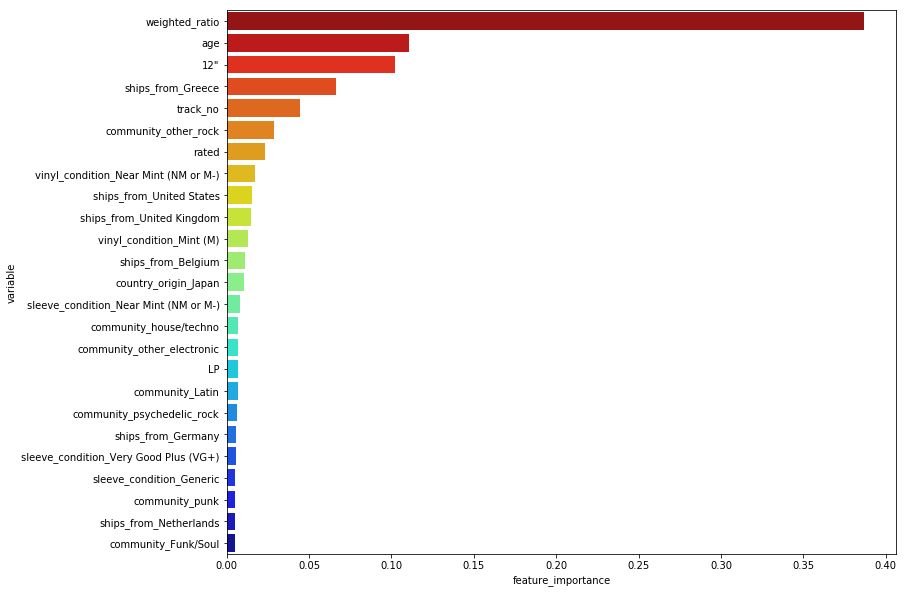

In [55]:
gbr=GradientBoostingRegressor(max_depth=4,subsample=0.8)
gbr.fit(X_train,y_train)

print('train score:',round(gbr.score(X_train, y_train),3))
print('test score:',round(gbr.score(X_test, y_test),3))
feature_importance=gbr.feature_importances_
variable=X_train.columns

test=pd.DataFrame({'variable':variable,
             'feature_importance':feature_importance}).sort_values(by='feature_importance',ascending=False).head(25)

plt.figure(figsize=(12,10))
ax = sns.barplot(x='feature_importance', y='variable', data=test, palette='jet_r')
#plt.xticks(rotation=90)
plt.show()

<a id="14"></a>
## Classification

Modelling price ranges

In [56]:
#recreating final dataset
df11=df9.join(binary_cols[acceptable_formats])
df11=df11[(df11.pound_value <100) ]

#turning target into a categorical variable
test=[]
for i in df11.pound_value:
    if  i <5:
        test.append('a: £0-5.')
    elif i <10:
        test.append('b: £5-10.')
    elif i <20:
        test.append('c: £10-20.')
    elif i <30:
        test.append('d: £20-30.')
    elif i <40:
        test.append('e: £30-40.')
    elif i <50:
        test.append('f: £40-50.')
    elif i <60:
        test.append('g: £50-60.')
    elif i <70:
        test.append('h: £60-70.')
    elif i <100:
        test.append('i: £70-100.')
    else:
        test.append('j: £100-1000000.')
        
df11['pound_value']=test

print(df11['pound_value'].value_counts())

print('baseline:',round(len(df11[df11.pound_value=='a: £0-5.'])/len(df11),4))


y2=df11.pop('pound_value')
X2=df11

a: £0-5.       12535
b: £5-10.      11008
c: £10-20.      6249
d: £20-30.      1685
e: £30-40.       761
f: £40-50.       436
i: £70-100.      205
g: £50-60.       197
h: £60-70.       129
Name: pound_value, dtype: int64
baseline: 0.3775


In [57]:
#Over Sampling to even out the class imbalance in price ranges
ros = RandomOverSampler(random_state=42)
X_r, y_r = ros.fit_resample(X2, y2)

X_r=pd.DataFrame(X_r, columns=X2.columns)
y_r=pd.DataFrame(y_r, columns=['price_range'])
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_r,y_r,test_size=0.5,random_state=1)

scaler2 = StandardScaler()

X_train2 = pd.DataFrame(scaler2.fit_transform(X_train2),columns=X_train2.columns)
X_test2 = pd.DataFrame(scaler2.transform(X_test2),columns=X_test2.columns)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)

train score: 0.3519953197298208
test score: 0.3448624308608708
              precision    recall  f1-score   support

    a: £0-5.       0.44      0.69      0.54      6211
   b: £5-10.       0.36      0.51      0.42      6371
  c: £10-20.       0.31      0.18      0.23      6253
  d: £20-30.       0.28      0.08      0.12      6227
  e: £30-40.       0.31      0.15      0.20      6275
  f: £40-50.       0.24      0.19      0.21      6372
  g: £50-60.       0.31      0.29      0.30      6209
  h: £60-70.       0.34      0.59      0.43      6152
 i: £70-100.       0.35      0.44      0.39      6338

   micro avg       0.34      0.34      0.34     56408
   macro avg       0.33      0.35      0.32     56408
weighted avg       0.33      0.34      0.32     56408

[[4316 1332  251   25   32   31  105   63   56]
 [1879 3233

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


train score: 0.2367968514546067
test score: 0.23119061126081406
              precision    recall  f1-score   support

    a: £0-5.       0.48      0.49      0.49      6211
   b: £5-10.       0.27      0.29      0.28      6371
  c: £10-20.       0.15      0.12      0.13      6253
  d: £20-30.       0.21      0.14      0.17      6227
  e: £30-40.       0.12      0.10      0.11      6275
  f: £40-50.       0.13      0.14      0.14      6372
  g: £50-60.       0.21      0.34      0.26      6209
  h: £60-70.       0.30      0.24      0.26      6152
 i: £70-100.       0.21      0.23      0.22      6338

   micro avg       0.23      0.23      0.23     56408
   macro avg       0.23      0.23      0.23     56408
weighted avg       0.23      0.23      0.23     56408

[[3022 1608  401  191  166  359  140  113  211]
 [1660 1833  513  434  350  608  366  247  360]
 [ 645  940  744  594  407  981  770  517  655]
 [ 286  589  677  881  385 1070 1007  575  757]
 [ 143  410  742  574  625  983 1338  5

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train score: 0.37560941017958765
test score: 0.36977024535526876
              precision    recall  f1-score   support

    a: £0-5.       0.52      0.74      0.62      6211
   b: £5-10.       0.42      0.52      0.46      6371
  c: £10-20.       0.32      0.21      0.26      6253
  d: £20-30.       0.35      0.09      0.15      6227
  e: £30-40.       0.34      0.17      0.23      6275
  f: £40-50.       0.24      0.18      0.20      6372
  g: £50-60.       0.33      0.33      0.33      6209
  h: £60-70.       0.34      0.63      0.44      6152
 i: £70-100.       0.34      0.47      0.40      6338

   micro avg       0.37      0.37      0.37     56408
   macro avg       0.36      0.37      0.34     56408
weighted avg       0.36      0.37      0.34     56408

[[4619 1218  146   12   26   32   68   46   44]
 [1901 3290  446   50   95   96  200  135  158]
 [ 878 1457 1333  206  351  417  579  618  414]
 [ 400  701  763  574  553  631  790  999  816]
 [ 324  399  510  191 1072  837  776 1

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


train score: 0.3833389472937756
test score: 0.3753722876187775
              precision    recall  f1-score   support

    a: £0-5.       0.58      0.71      0.64      6211
   b: £5-10.       0.46      0.49      0.48      6371
  c: £10-20.       0.34      0.28      0.30      6253
  d: £20-30.       0.30      0.14      0.19      6227
  e: £30-40.       0.32      0.22      0.26      6275
  f: £40-50.       0.25      0.22      0.23      6372
  g: £50-60.       0.30      0.32      0.31      6209
  h: £60-70.       0.36      0.58      0.44      6152
 i: £70-100.       0.36      0.44      0.39      6338

   micro avg       0.38      0.38      0.38     56408
   macro avg       0.36      0.38      0.36     56408
weighted avg       0.36      0.38      0.36     56408

[[4420 1181  299   29   49   39  101   46   47]
 [1596 3109  758  122  148  129  242  124  143]
 [ 661 1092 1725  383  448  485  637  475  347]
 [ 309  403  832  860  700  773  811  804  735]
 [ 192  245  576  420 1353  876  789 105

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


train score: 0.8148456751821582
test score: 0.7908098142107503
              precision    recall  f1-score   support

    a: £0-5.       0.69      0.67      0.68      6211
   b: £5-10.       0.55      0.49      0.52      6371
  c: £10-20.       0.49      0.40      0.44      6253
  d: £20-30.       0.62      0.68      0.65      6227
  e: £30-40.       0.80      0.92      0.85      6275
  f: £40-50.       0.95      0.98      0.96      6372
  g: £50-60.       0.97      0.98      0.98      6209
  h: £60-70.       0.99      1.00      0.99      6152
 i: £70-100.       0.98      1.00      0.99      6338

   micro avg       0.79      0.79      0.79     56408
   macro avg       0.78      0.79      0.79     56408
weighted avg       0.78      0.79      0.78     56408

[[4163 1275  427  195  100   25   10    4   12]
 [1329 3150 1122  483  187   52   18    7   23]
 [ 438  985 2483 1582  510  124   63   25   43]
 [  73  267  877 4247  607   81   21    6   48]
 [   0    0  136  280 5771   41   34   1

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train score: 0.9965252539578421
test score: 0.8974258970358814
              precision    recall  f1-score   support

    a: £0-5.       0.71      0.75      0.73      6211
   b: £5-10.       0.66      0.60      0.63      6371
  c: £10-20.       0.78      0.75      0.77      6253
  d: £20-30.       0.94      0.98      0.96      6227
  e: £30-40.       0.98      1.00      0.99      6275
  f: £40-50.       0.99      1.00      1.00      6372
  g: £50-60.       1.00      1.00      1.00      6209
  h: £60-70.       1.00      1.00      1.00      6152
 i: £70-100.       1.00      1.00      1.00      6338

   micro avg       0.90      0.90      0.90     56408
   macro avg       0.90      0.90      0.90     56408
weighted avg       0.90      0.90      0.90     56408

[[4665 1144  351   35    6    7    2    0    1]
 [1517 3811  904   96   29    9    1    0    4]
 [ 388  785 4714  267   65   17   12    0    5]
 [   4   22   89 6086   16    4    6    0    0]
 [   0    0    0    0 6275    0    0    

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train score: 1.0
test score: 0.8953162671961424
              precision    recall  f1-score   support

    a: £0-5.       0.69      0.74      0.71      6211
   b: £5-10.       0.65      0.59      0.62      6371
  c: £10-20.       0.79      0.75      0.77      6253
  d: £20-30.       0.95      0.98      0.96      6227
  e: £30-40.       0.98      1.00      0.99      6275
  f: £40-50.       0.99      1.00      1.00      6372
  g: £50-60.       1.00      1.00      1.00      6209
  h: £60-70.       1.00      1.00      1.00      6152
 i: £70-100.       1.00      1.00      1.00      6338

   micro avg       0.90      0.90      0.90     56408
   macro avg       0.89      0.90      0.89     56408
weighted avg       0.89      0.90      0.89     56408

[[4615 1208  343   30    7    6    0    1    1]
 [1642 3768  830   89   26   11    2    0    3]
 [ 451  800 4690  219   56   18   11    2    6]
 [  23   28   73 6084   19    0    0    0    0]
 [   0    0    0    0 6275    0    0    0    0]
 [   0 

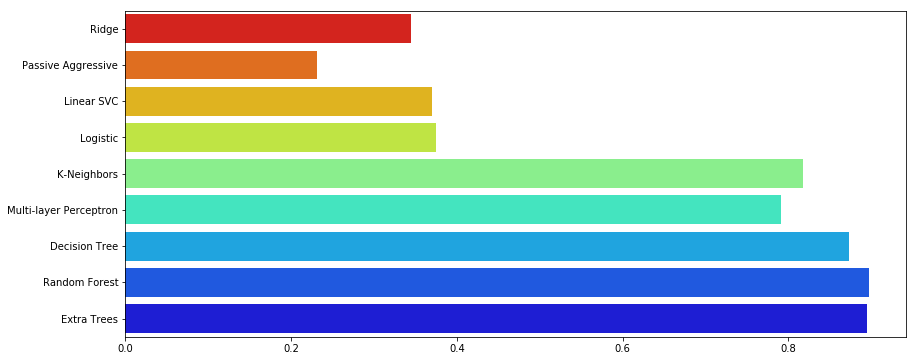

In [58]:
models = [ RidgeClassifier(),
           PassiveAggressiveClassifier(),
           LinearSVC(),
           LogisticRegression(),
           KNeighborsClassifier(),
           MLPClassifier(hidden_layer_sizes=(30,30,30)),
           DecisionTreeClassifier(),  
           RandomForestClassifier(), 
           ExtraTreesClassifier(),
           ]

results = []

for model in models:
    print(model)
    print()
    model.fit(X_train2, y_train2.price_range.ravel())
    y_pred = model.predict(X_test2)
    score = accuracy_score(y_test2, y_pred)
    print('train score:',model.score(X_train2,y_train2))
    print('test score:',model.score(X_test2,y_test2))
    print(classification_report(y_test2,y_pred))
    print((confusion_matrix(y_test2, y_pred)))
    print() 
    results.append([model, score])
    print() 
    print('-'*60)
    print()
    
#Random forest gives insane results. 
#Decision Tree also very good, can make a visualisation for it.


scores=[]
for i in range(0,len(models)):
    scores.append(results[i][1])
    
model_=['Ridge','Passive Aggressive','Linear SVC','Logistic','K-Neighbors','Multi-layer Perceptron',
        'Decision Tree','Random Forest','Extra Trees']    

plt.figure(figsize=(14,6))
ax = sns.barplot(x=scores, y=model_, palette='jet_r')
plt.show()

 <a id="16b"></a>
### Tuning Random Forest

In [73]:
params = {"n_estimators": [5,10,20,30],
          "criterion": ["gini","entropy"],
          "min_samples_split":[5,10,20,100],
          "max_features":["auto",None]
          }

rf = RandomForestClassifier()
rf_search = RandomizedSearchCV(rf, param_distributions=params ,n_iter=40, cv=3, verbose=1)
rf_search.fit(X_train2, y_train2)

print('train score:',round(rf_search.score(X_train2, y_train2),2))
print('test score:',round(rf_search.score(X_test2, y_test2),2))

rf_search.best_params_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selectio

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

train score: 0.99
test score: 0.9


{'n_estimators': 30,
 'min_samples_split': 5,
 'max_features': 'auto',
 'criterion': 'gini'}

In [60]:
rf = RandomForestClassifier(n_estimators=10,min_samples_split=25)
rf.fit(X_train2, y_train2)
predictions=rf.predict(X_test2)

print('train score:',rf.score(X_train2,y_train2))
print('test score:',rf.score(X_test2,y_test2))

print(classification_report(y_test2,predictions))
print((confusion_matrix(y_test2, predictions)))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


train score: 0.9114648891095077
test score: 0.8534427740745993
              precision    recall  f1-score   support

    a: £0-5.       0.69      0.73      0.71      6211
   b: £5-10.       0.61      0.53      0.57      6371
  c: £10-20.       0.67      0.58      0.62      6253
  d: £20-30.       0.82      0.87      0.84      6227
  e: £30-40.       0.90      0.97      0.94      6275
  f: £40-50.       0.95      1.00      0.97      6372
  g: £50-60.       0.99      1.00      0.99      6209
  h: £60-70.       1.00      1.00      1.00      6152
 i: £70-100.       0.99      1.00      0.99      6338

   micro avg       0.85      0.85      0.85     56408
   macro avg       0.85      0.85      0.85     56408
weighted avg       0.85      0.85      0.85     56408

[[4546 1106  405   97   34   15    5    0    3]
 [1441 3392 1052  293  125   36   10    3   19]
 [ 485  881 3648  743  284  134   41    4   33]
 [ 112  128  268 5390  202  104    9    0   14]
 [   0   11   53   60 6115   17    0    

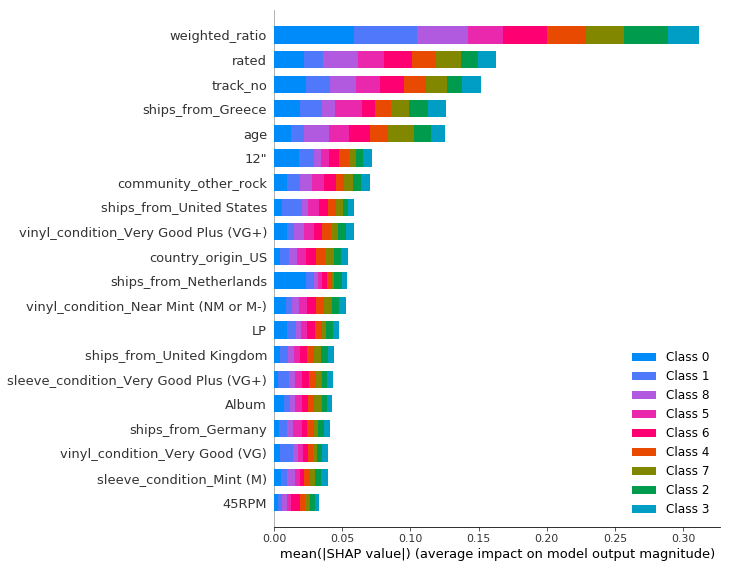

In [61]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test2[10000:10300])

shap.summary_plot(shap_values, X_test2[10000:10300])

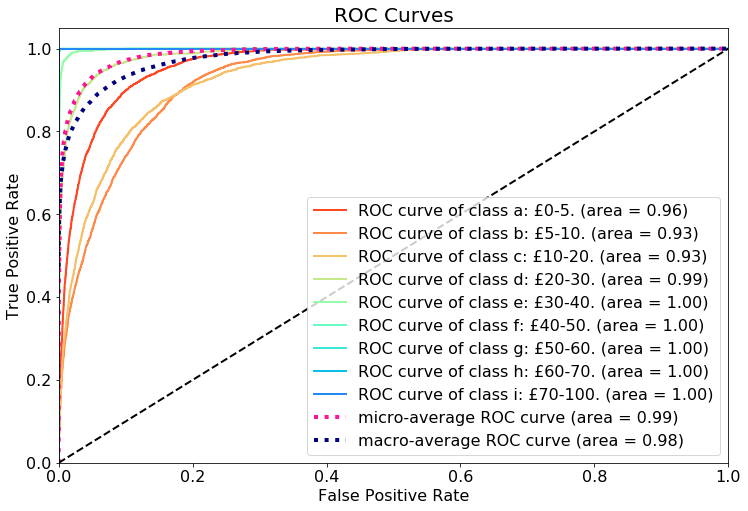

In [62]:
probabilities=rf.predict_proba(X_test2)
cmap = ListedColormap(sns.color_palette('rainbow_r',10))

skplt.metrics.plot_roc(y_test2, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(12,8), cmap=cmap)
plt.show()

<a id="17"></a>
## Applying Predictions

In [70]:
#pred=[round(x,2) for x in gbr.predict(X)]
pred=[x for x in gbr.predict(scaler.transform(X))]
actuals=y

pred_range=rf.predict(scaler2.transform(X2))
actual_range=y2


final=pd.DataFrame({'actual_value':actuals,
                    'predicted':pred,
                    'actual_range':actual_range,
                    'predicted_range':pred_range,
                    })

final['lower']=[int(str(re.search(r"£(.*).",x).group(1)).split('-')[0]) for x in pred_range]
final['upper']=[int(str(re.search(r"£(.*).",x).group(1)).split('-')[1]) for x in pred_range]
final['trust']=[1 if (x>y) & (x<z) else 0 for x,y,z in zip(final.predicted,final.lower,final.upper)]
final['price_difference']=final.predicted-final.actual_value
final['url']=urls

final.head(10)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


,actual_value,predicted,actual_range,predicted_range,lower,upper,trust,price_difference,url
0,3.51,5.122094,a: £0-5.,a: £0-5.,0,5,0,1.612094,https://www.discogs.com/sell/item/807784935
1,4.54,6.164546,a: £0-5.,b: £5-10.,5,10,1,1.624546,https://www.discogs.com/sell/item/845147022
2,45.00,8.439979,f: £40-50.,f: £40-50.,40,50,0,-36.560021,https://www.discogs.com/sell/item/854348855
3,27.00,28.077538,d: £20-30.,d: £20-30.,20,30,1,1.077538,https://www.discogs.com/sell/item/854348856
4,7.89,15.218077,b: £5-10.,d: £20-30.,20,30,0,7.328077,https://www.discogs.com/sell/item/854348853
5,22.12,9.757727,d: £20-30.,c: £10-20.,10,20,0,-12.362273,https://www.discogs.com/sell/item/305018181
6,2.36,3.212696,a: £0-5.,a: £0-5.,0,5,1,0.852696,https://www.discogs.com/sell/item/355113031
7,22.50,5.501401,d: £20-30.,d: £20-30.,20,30,0,-16.998599,https://www.discogs.com/sell/item/854348852
8,11.96,10.255840,c: £10-20.,i: £70-100.,70,100,0,-1.704160,https://www.discogs.com/sell/item/854348851
9,6.12,6.598295,b: £5-10.,b: £5-10.,5,10,1,0.478295,https://www.discogs.com/sell/item/807784892


In [71]:
len(final[final.trust==1])/len(final)

0.553952717964162

In [72]:
test=final[(final.actual_range!='a: £0-5.') & (final.actual_range!='b: £5-10.')]

test2=test[(test.trust==1) & (test.price_difference>5)]\
[['url','price_difference']].sort_values(by='price_difference',ascending=False)

sum(test2.price_difference)

test2

,url,price_difference
16496,https://www.discogs.com/sell/item/776787963,29.247545
33016,https://www.discogs.com/sell/item/635476078,26.500771
17585,https://www.discogs.com/sell/item/640194081,23.179400
10402,https://www.discogs.com/sell/item/847989965,23.136641
1947,https://www.discogs.com/sell/item/746757095,22.404194
32635,https://www.discogs.com/sell/item/430394780,20.061673
19800,https://www.discogs.com/sell/item/854346361,19.031505
22299,https://www.discogs.com/sell/item/840050463,17.729937
18998,https://www.discogs.com/sell/item/159940963,17.631701
17720,https://www.discogs.com/sell/item/606430730,17.452994
